In [1]:
import torch
import torch.nn as nn

from tqdm import tqdm
from functools import partial
from dataclasses import dataclass
from collections import OrderedDict
import pickle
import matplotlib.pyplot as plt

def getCNNdata(epochs, dtyp, epoch_start=0, epoch_end=1000):
    data = {"train": [], "val": [], "test": []}

    for epoch in range(epoch_start, epoch_end):
        for phase in epochs[epoch].keys():
            data[phase] = data[phase] + [epochs[epoch][phase][dtyp]]
            #aucs[phase] = aucs[phase] + [cnn_epochs[epoch][phase]["auc"]]
    return data

# Implementing ResNet in PyTorch
Today we are going to implement the famous ResNet from Kaiming He et al. (Microsoft Research). It won the 1st place on the ILSVRC 2015 classification task.

The original paper can be read from [here ](https://arxiv.org/abs/1512.03385) and it is very easy to follow, additional material can be found in this [quora answer](https://www.quora.com/)
![alt](./images/custom/rotated-resnet34.png)

*Deeper neural networks are more difficult to train.* Why? One big problem of deeper network is the vanishing gradient. Basically, the model is not able to learn anymore.

To solve this problem, the Authors proposed to use a reference to the previous layer to compute the output at a given layer. In ResNet, the output form the previous layer, called **residual**, is added to the output of the current layer. The following picture visualizes this operation

![alt](./images/residual.png)

We are going to make our implementation **as scalable as possible** using one think think unknown to mostly of the data scientiest: **object orienting programming**

## Basic Block

Okay, the first thing is to think about what we need. Well, first of all we need a convolution layer and since PyTorch does not have the 'auto' padding in Conv2d, so we have to code ourself!

In [2]:
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)      
        

In [3]:
conv = conv3x3(in_channels=32, out_channels=64)
print(conv)
del conv

Conv2dAuto(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


## Residual Block
To make clean code is mandatory to think about the main building block of each application, or of the network in our case. The residual block takes an input with `in_channels`, applies some blocks of convolutional layers to reduce it to `out_channels` and sum it up to the original input. If their sizes mismatch, then the input goes into an `identity`. We can abstract this process and create a interface that can be extedend.

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels, self.out_channels =  in_channels, out_channels
        self.blocks = nn.Identity()
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

In [5]:
ResidualBlock(32, 64)

ResidualBlock(
  (blocks): Identity()
  (shortcut): Identity()
)

Let's test it with a dummy vector with one one, we should get a vector with two

In [6]:
dummy = torch.ones((1, 1, 1, 1))

block = ResidualBlock(1, 64)
block(dummy)

tensor([[[[2.]]]])

In ResNet each block has a expansion parameter in order to increase the `out_channels`. Also, the identity is defined as a Convolution followed by an Activation layer, this is referred as `shortcut`. Then, we can just extend `ResidualBlock` and defined the `shortcut` function.

In [7]:
from collections import OrderedDict

class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(OrderedDict(
        {
            'conv' : nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            'bn' : nn.BatchNorm2d(self.expanded_channels)
            
        })) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

In [8]:
ResNetResidualBlock(32, 64)

ResNetResidualBlock(
  (blocks): Identity()
  (shortcut): Sequential(
    (conv): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

### Basic Block
A basic ResNet block is composed by two layers of `3x3` convs/batchnorm/relu. In the picture, the lines represnet the residual operation. The dotted line means that the shortcut was applied to match the input and the output dimension.
![alt](./images/custom/Block.png)

Let's first create an handy function to stack one conv and batchnorm layer. Using `OrderedDict` to properly name each sublayer.

In [9]:
from collections import OrderedDict
def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(OrderedDict({'conv': conv(in_channels, out_channels, *args, **kwargs), 
                          'bn': nn.BatchNorm2d(out_channels) }))

In [10]:
conv_bn(3, 3, nn.Conv2d, kernel_size=3)

Sequential(
  (conv): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [11]:
class ResNetBasicBlock(ResNetResidualBlock):
    expansion = 1
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation(),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )
    

In [12]:
dummy = torch.ones((1, 32, 224, 224))

block = ResNetBasicBlock(32, 64)
block(dummy).shape
print(block)

ResNetBasicBlock(
  (blocks): Sequential(
    (0): Sequential(
      (conv): Conv2dAuto(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ReLU()
    (2): Sequential(
      (conv): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (shortcut): Sequential(
    (conv): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


### BottleNeck
To increase the network deepths but to decrese the number of parameters, the Authors defined a BottleNeck block that 
"The three layers are 1x1, 3x3, and 1x1 convolutions, where the 1×1 layers are responsible for reducing and then increasing (restoring) dimensions, leaving the 3×3 layer a bottleneck with smaller input/output dimensions." We can extend the `ResNetResidualBlock` and create these blocks.

In [13]:
class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
             activation(),
             conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
             activation(),
             conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
        )
    

In [14]:
dummy = torch.ones((1, 32, 10, 10))

block = ResNetBottleNeckBlock(32, 64)
block(dummy).shape
print(block)

ResNetBottleNeckBlock(
  (blocks): Sequential(
    (0): Sequential(
      (conv): Conv2dAuto(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ReLU()
    (2): Sequential(
      (conv): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ReLU()
    (4): Sequential(
      (conv): Conv2dAuto(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (shortcut): Sequential(
    (conv): Conv2d(32, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


### Layer
A ResNet's layer is composed by blocks stacked one after the other. 

![alt](./images/custom/Layer.png)

We can easily defined it by just stuck `n` blocks one after the other, just remember that the first convolution block has a stide of two since "We perform downsampling directly by convolutional layers that have a stride of 2".

In [15]:
class ResNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x

In [16]:
dummy = torch.ones((1, 32, 48, 48))

layer = ResNetLayer(64, 128, block=ResNetBasicBlock, n=3)
# layer(dummy).shape
layer

ResNetLayer(
  (blocks): Sequential(
    (0): ResNetBasicBlock(
      (blocks): Sequential(
        (0): Sequential(
          (conv): Conv2dAuto(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): ReLU()
        (2): Sequential(
          (conv): Conv2dAuto(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (shortcut): Sequential(
        (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResNetBasicBlock(
      (blocks): Sequential(
        (0): Sequential(
          (conv): Conv2dAuto(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn

### Encoder
Similarly, the encoder is composed by multiple layer at increasing features size.

![alt](./images/custom/rotated-Encoder.png)



In [17]:
class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by increasing different layers with increasing features.
    """
    def __init__(self, in_channels=3, blocks_sizes=[64, 128, 256, 512], deepths=[2,2,2,2], 
                 activation=nn.ReLU, block=ResNetBasicBlock, *args,**kwargs):
        super().__init__()
        
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=deepths[0], activation=activation, 
                        block=block,  *args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]       
        ])
        
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x

## Decoder
The decoder is the last piece we need to create the full network. It is a fully connected layer that maps the features learned by the network to their respective classes. Easily, we can defined it as:

In [18]:
class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x


## ResNet

Final, we can put all the pieces together and create the final model.

![alt](./images/custom/rotated-resnet34.png)

In [19]:
class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs).to(device)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes).to(device)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

We can now defined the five models proposed by the Authors, `resnet18,34,50,101,152`

In [20]:
def resnet18(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[2, 2, 2, 2])

def resnet34(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[3, 4, 6, 3])

def resnet50(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 6, 3])

def resnet101(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 23, 3])

def resnet152(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 8, 36, 3])

In [21]:
from torchsummary import summary

model = resnet18(70, 2)
summary(model.cuda(), (3, 224, 224))

NameError: name 'device' is not defined

In [ ]:
import torchvision.models as models

# resnet101(False)

summary(models.resnet18(False).cuda(), (3, 224, 224))

In [59]:
import os
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import torch.optim as optim
from sklearn.metrics import roc_auc_score

In [60]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [245]:
vers = "16.4"
features = "polar-channelled"
lag = "0"
window_size = "10"
model_save_dir = os.getcwd() + f"/ml-models/db{vers}/{features}-lag{lag}-ws{window_size}/"

In [246]:
def loadNpy(filename):
    with open(os.getcwd() + "/train-val-test/"+ filename, "rb") as f: return np.load(f)

db = f"db{vers}/window-size-{window_size}/lag{lag}/{features}-features/"
xdtype = "std-"
ydtype = "exi-"

In [247]:
DIR = os.getcwd() + "/train-val-test/" + db

In [248]:
X_train, X_val, X_test = loadNpy(db + f"{xdtype}X_train.npy"), loadNpy(db + f"{xdtype}X_val.npy"), loadNpy(db + f"{xdtype}X_test.npy")
y_train, y_val, y_test = loadNpy(db + f"{ydtype}y_train.npy"), loadNpy(db + f"{ydtype}y_val.npy"), loadNpy(db + f"{ydtype}y_test.npy")

In [249]:
minAcc = np.mean(y_train)
print(minAcc)

0.20058926580665712


In [250]:
y_train

array([0., 0., 0., ..., 0., 0., 1.])

In [251]:
print(np.where(np.logical_and(y_train != 1, y_train != 0)))
print(len(y_train))

(array([], dtype=int64),)
37674


In [252]:
np.where(X_train == -np.inf)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [253]:
def npy_to_tensor(data, l=False):
    if not l:
        data = torch.from_numpy(data).float()
    else:
        data = torch.from_numpy(data).type(torch.LongTensor)
    return data

In [254]:
X_train, X_val, X_test = npy_to_tensor(X_train), npy_to_tensor(X_val), npy_to_tensor(X_test)
y_train, y_val, y_test = npy_to_tensor(y_train, 1), npy_to_tensor(y_val, 1), npy_to_tensor(y_test, 1)

In [255]:
batch_size = 32

In [256]:
train_dataset = TensorDataset(X_train, y_train)

val_dataset = TensorDataset(X_val, y_val)

test_dataset = TensorDataset(X_test, y_test)

# Data loader
train_iterator = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=False)

val_iterator = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

test_iterator = DataLoader(dataset=test_dataset, batch_size=batch_size,shuffle=False)

In [257]:
X_train.shape

torch.Size([37674, 10, 75])

In [258]:
loaders = {
    'train': train_iterator,
    'val': val_iterator,
    'test': test_iterator
}

In [35]:
from libauc.losses import AUCMLoss, SOAPLoss, APLoss_SH
from libauc.optimizers import PESG, SOAP_ADAM, SOAP_SGD
from sklearn.metrics import roc_auc_score

In [37]:
imratio = minAcc
SEED = 123
BATCH_SIZE = 64
lr =  1e-2
weight_decay = 2e-4
margin = 0.6
beta = 0.99 # this refers to gamma for moving average in the paper
posNum = 1

In [38]:
rn = resnet18(1, 2)#.to(device)
torch.manual_seed(SEED)

In [48]:
loss_func = AUCMLoss(imratio=imratio)
loss_func

AUCMLoss()

In [36]:
optimizer = PESG(rn, 
                 a=loss_func.a, 
                 b=loss_func.b, 
                 alpha=loss_func.alpha, 
                 imratio=imratio, 
                 lr=lr, 
                 gamma=beta, 
                 margin=margin, 
                 weight_decay=weight_decay) #optim.Adam(rn.parameters(), lr = 0.0001, weight_decay=5e-2)   
optimizer

PESG (
Parameter Group 0
    a: tensor([0.], device='cuda:0', requires_grad=True)
    alpha: tensor([0.], device='cuda:0', requires_grad=True)
    b: tensor([0.], device='cuda:0', requires_grad=True)
    clip_value: 1.0
    gamma: 0.99
    lr: 0.01
    margin: 0.6
    model_acc: [tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0.,

In [98]:
swa_model = torch.optim.swa_utils.AveragedModel(rn)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)
swa_start = 160
swa_scheduler = optim.swa_utils.SWALR(optimizer, swa_lr=0.05)
sched_type = "swa"

In [259]:
torch.cuda.empty_cache()

rn = resnet18(1, 2)#.to(device)
torch.manual_seed(123)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(rn.parameters(), lr = 0.01, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)
sched_type = ""

num_epochs = 100
nn_epochs = {}

# Train the model
total_step = len(train_iterator)
for epoch in tqdm(range(num_epochs)):
    nn_epochs[epoch] = {}
    losses = []
    #running_loss = 0
    
    for phase in ["train", "val", "test"]:
        total_step = len(loaders[phase].dataset)
        correct = 0
        total = 0
        pred_ys = []
        labs = []
        
        if phase == "train":
            rn.train(True)
            
            for i, (images, labels) in enumerate(loaders[phase]):
                images = images[:,None,:,:].to(device)
                labels = labels.to(device)
                
                outputs = rn(images)
                pred_y = torch.max(outputs, 1)[1].data.squeeze()
                
                loss = loss_func(outputs, labels)

                losses.append(loss.item())
                optimizer.zero_grad()

                loss.backward()
                optimizer.step()

                pred_ys = pred_ys + pred_y.tolist()
                labs = labs + labels.tolist()
                total += len(labels)
                correct += (pred_y == labels).sum().item()
        else:
            rn.train(False)
            
            with torch.no_grad():
                for i, (images, labels) in enumerate(loaders[phase]):
                    images = images[:,None,:,:].to(device)
                    labels = labels.to(device)
                    
                    outputs = rn(images)
                    pred_y = torch.max(outputs, 1)[1].data.squeeze()
                    
                    loss = loss_func(outputs, labels)

                    losses.append(loss.item())
                    optimizer.zero_grad()
                    
                    pred_ys = pred_ys + pred_y.tolist() #test_output.flatten().tolist()
                    labs = labs + labels.tolist()
                    total += len(labels)
                    correct += (pred_y == labels).sum().item()
        """
        for i, (images, labels) in enumerate(loaders[phase]):  
            # Move tensors to the configured device
            #print(images.shape)
            images = images[:,None,:,:].to(device)
            labels = labels.to(device)

            # Forward pass
            #print(images.shape)
            outputs = rn(images)
            #print(torch.max(outputs, 1)[1])
            pred_y = torch.max(outputs, 1)[1].data.squeeze()
            ##print(outputs.shape)
            #print(labels.shape)
            #print(pred_y.shape)
            #pred_y = torch.max(outputs, 1)[1].data.squeeze()
            loss = loss_func(outputs, labels)
            
            losses.append(loss.item())
            #running_loss += loss.item()
            # Backward and optimize
            optimizer.zero_grad()
            
            if phase == "train":
                loss.backward()
                optimizer.step()
            #print(i)


            #print(pred_y)
            pred_ys = pred_ys + pred_y.tolist() #test_output.flatten().tolist()
            labs = labs + labels.tolist()
            total += len(labels)
            correct += (pred_y == labels).sum().item()
            """

       # print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
        #       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

        #print(f'Accuracy of the model on the {total} images: %.3f' % (correct/total))

        cm = np.zeros((2,2))
        for i, p in enumerate(pred_ys):
            label = labs[i]
            cm[label, p] += 1

        #print(f"Sensitivity = {cm[1,1]/(cm[1,1] + cm[1,0])}")
        #print(f"Specificity = {cm[0,0]/(cm[0,0] + cm[0,1])}")
        #print(f"AUC = {roc_auc_score(labs, pred_ys)}")

        nn_epochs[epoch][phase] = {"loss": loss.item(), "acc": correct/total, 
                                 "sens": cm[1,1]/(cm[1,1] + cm[1,0]), "spec": cm[0,0]/(cm[0,0] + cm[0,1]),
                                "auc": roc_auc_score(labs, pred_ys)}

    #print()
    avg_loss = sum(losses)/len(losses)
    scheduler.step(avg_loss)

    if sched_type == "swa":
        if epoch > swa_start:
            swa_model.update_parameters(rn)
            swa_scheduler.step()
        else:
            scheduler.step()
    elif sched_type == "12":         
        scheduler1.step()
        scheduler2.step()

100%|█████████████████████████████████████████| 100/100 [19:29<00:00, 11.69s/it]


In [260]:
with open(f"{model_save_dir}ep{num_epochs}-bs{batch_size}-{xdtype}{ydtype}resnet18-sgd-lr0.01-lrplat.pickle", "ab") as f:
    pickle.dump(nn_epochs, f)

Text(0.5, 1.05, 'ResNet18 (polar channelled features, lag 0ms, ws 10)\nusing standardisation and label existence')

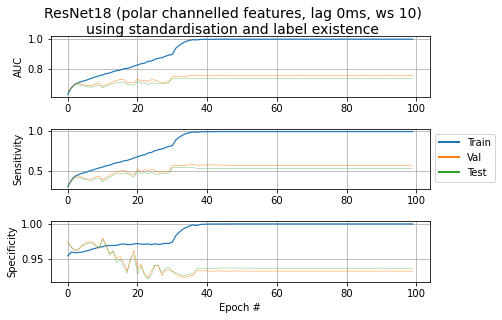

In [261]:
fig, axs = plt.subplots(3)
fig.tight_layout()

losses = getCNNdata(nn_epochs, "loss", 0, num_epochs)
aucs = getCNNdata(nn_epochs, "auc", 0, num_epochs)
sens = getCNNdata(nn_epochs, "sens", 0, num_epochs)
specs = getCNNdata(nn_epochs, "spec", 0, num_epochs)
#print(aucs)
lw = 0.3

#val_aucs = [el*1.1 for el in aucs["val"]]
#test_aucs = [el*1.1 for el in aucs["test"]]

    
axs[0].plot(np.arange(len(aucs["train"])), aucs["train"], label="Train", lw=lw*4)
axs[0].plot(np.arange(len(aucs["val"])), aucs["val"], label="Val", lw=lw*1.5)
axs[0].plot(np.arange(len(aucs["test"])), aucs["test"], label="Test", lw=lw)
#axs[0].set_xlabel("Epoch #")
axs[0].set_ylabel("AUC")
axs[0].grid(True)


axs[1].plot(np.arange(len(sens["train"])), sens["train"], label="Train", lw=lw*4)
axs[1].plot(np.arange(len(sens["val"])), sens["val"], label="Val", lw=lw*1.5)
axs[1].plot(np.arange(len(sens["test"])), sens["test"], label="Test", lw=lw)
#axs[1].set_xlabel("Epoch #")
axs[1].set_ylabel("Sensitivity")
axs[1].grid(True)

leg = axs[1].legend(bbox_to_anchor=(1, 1))
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.0)

#axs[1].legend(bbox_to_anchor=(1, 1))

axs[2].plot(np.arange(len(specs["train"])), specs["train"], label="Train", lw=lw*4)
axs[2].plot(np.arange(len(specs["val"])), specs["val"], label="Val", lw=lw*1.5)
axs[2].plot(np.arange(len(specs["test"])), specs["test"], label="Test", lw=lw)
axs[2].set_xlabel("Epoch #")
axs[2].set_ylabel("Specificity")
axs[2].grid(True)
#axs[1].legend(lw=1)
    
plt.suptitle(f"ResNet18 (polar channelled features, lag 0ms, ws 10)\nusing standardisation and label existence",y=1.05, fontsize=14)

In [262]:
opt = "test"
idx = np.where(aucs[opt] == np.max(aucs[opt]))[0][0]
print("AUC:")
print(aucs["train"][idx])
print(aucs["val"][idx])
print(aucs["test"][idx])
print("Sens:")
print(sens["train"][idx])
print(sens["val"][idx])
print(sens["test"][idx])
print("Spec:")
print(specs["train"][idx])
print(specs["val"][idx])
print(specs["test"][idx])

print(idx)

AUC:
0.9390153049131941
0.7497461892562822
0.7389977502620266
Sens:
0.8950641789069737
0.5722178374112076
0.5482668654491241
Spec:
0.9829664309194143
0.9272745411013568
0.9297286350749291
31


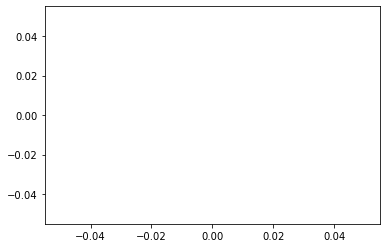

In [193]:
plt.plot(np.arange(len(losses["train"])), losses["train"], label="Train", lw=lw*4)
plt.plot(np.arange(len(losses["val"])), losses["val"], label="Val", lw=lw*1.5)
plt.plot(np.arange(len(losses["test"])), losses["test"], label="Test", lw=lw)

In [238]:
losses

{'train': [7.270035266876221,
  0.515286386013031,
  0.5183351039886475,
  0.5408487319946289,
  0.5167276859283447,
  0.5146437883377075,
  0.5169643759727478,
  0.5154601335525513,
  0.5274099111557007,
  0.5202822685241699,
  0.5189491510391235,
  0.5256572365760803,
  0.5200202465057373,
  0.5174275636672974,
  0.5167351961135864,
  0.5166274309158325,
  0.5167020559310913,
  0.516844630241394,
  0.5177151560783386,
  0.5175105333328247,
  0.5173516869544983,
  0.5161396265029907,
  0.5169404745101929,
  0.5191710591316223,
  0.5198994874954224,
  0.519963264465332,
  0.5196201205253601,
  0.5189990997314453,
  0.5184279680252075,
  0.5180664658546448,
  0.5178685784339905,
  0.5177380442619324,
  0.5176403522491455,
  0.5175607204437256,
  0.517490804195404,
  0.5174334049224854,
  0.5173697471618652,
  0.5173293352127075,
  0.517278254032135,
  0.5172346234321594,
  0.5159891843795776,
  0.5156828761100769,
  0.5155401229858398,
  0.5154498219490051,
  0.5153809785842896,
  0.515

In [101]:
accs = getCNNdata(nn_epochs, "acc", 0, num_epochs)

KeyError: 1

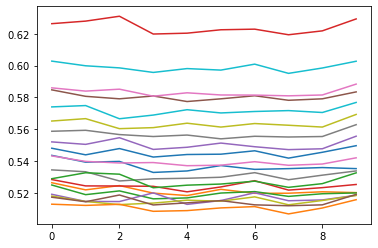

In [117]:
sample = X_train[6,:,13:33]

plt.plot(np.arange(10), sample)

In [111]:
y_train[6]

tensor(1)

In [109]:
y_train

tensor([0, 0, 0,  ..., 0, 0, 1])

In [110]:
np.where(y_train == 1)

(array([    6,    13,    49, ..., 37668, 37669, 37673]),)

In [ ]:
num_epochs = 10
nn_epochs = {}

# Train the model
total_step = len(val_iterator)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(val_iterator):  
        # Move tensors to the configured device
        #print(images.shape)
        images = images.reshape(-1, 70, 70, 70).to(device)
        labels = labels.to(device)
        
        # Forward pass
        #print(images.shape)
        outputs = rn(images)
        pred_y = torch.max(outputs, 1)[1].data.squeeze()
        loss = loss_func(pred_y, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(i)

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    nn_epochs[epoch] = {"loss": loss.item(), #"train": eval_rn(rn, "train"), 
                 "val": eval_rn(rn, "val"), "test": eval_rn(rn, "test")}
    rn.train()